In [1]:
%cd ..

/home/gianscarpe/dev/event-camera


In [2]:
from experimenting.dataset import DHP3DDataset, get_dataloader
from experimenting.dataset.indexes import get_dataset_params
from experimenting.utils import get_file_paths, decay_heatmap
from matplotlib import pyplot as plt
from os.path import join, basename
import numpy as np
from albumentations import Compose, CenterCrop
from albumentations.pytorch import ToTensor
import torch
from omegaconf import DictConfig
from experimenting.utils import get_file_paths, get_preload_dir, get_label_from_filename

%matplotlib inline

## 

In [3]:
# Augmentation
aug = Compose([ToTensor()])

In [19]:
data_dir = '/data/dhp19/movements_per_frame'
labels_dir = '/home/gianscarpe/dev/data/dhp19/time_count_dataset/labels'

hparams = DictConfig({'path': data_dir, 'labels_dir' : labels_dir})
file_paths, train_index, val_index, test_index, _ = get_dataset_params(hparams)

LOADED INDEXES! train: 224550 	 val: 56138 	 test: 70172


In [20]:
d = DHP3DDataset(file_paths, labels_dir, train_index, transform=aug)
loader = get_dataloader(d, 1, 2)



In [30]:
a = np.load('/home/gianscarpe/dev/data/dhp19/time_count_dataset/labels/S10_session_4_mov_1_frame_7_cam_0_2dhm.npy')

In [42]:
f2= get_file_paths('/data/dhp19/movements_per_frame', extensions=['npy'])
l = get_file_paths(labels_dir, extensions=['npy'])

npy
npy


In [44]:
len(f2)

350860

In [21]:
def display(img):                                                               
        fig, ax = plt.subplots(ncols=img.shape[0], nrows=1,                              
                               figsize=(20,20))                                                                                   
        for i in range(img.shape[0]):                                                                
            ax[i].imshow(img[i])                                                  
            ax[i].axis('off')                                                             
        plt.show()

In [22]:
batch = next(iter(loader))
x, y, gt_info = batch

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcdb30c680>
Traceback (most recent call last):
  File "/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/gianscarpe/dev/event-camera/experimenting/dataset/dataset.py", line 122, in __getitem__
    xyz, joints, mask, y = self._get_y(idx)
  File "/home/gianscarpe/dev/event-camera/experimenting/dataset/dataset.py", line 113, in _get_y
    xyz, joints, mask, heatmap = np.load(joints_file, allow_pickle=True)
ValueError: too many values to unpack (expected 4)


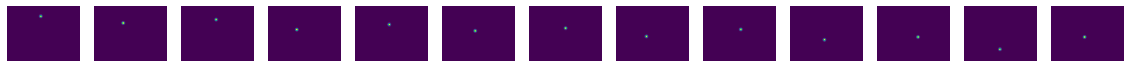

In [12]:
display(y[0])

In [19]:
gt_info['joints']

tensor([[[ 48, 160],
         [ 80, 138],
         [ 64, 166],
         [111, 136],
         [ 87, 162],
         [117, 157],
         [104, 173],
         [143, 144],
         [110, 179],
         [159, 163],
         [146, 194],
         [204, 170],
         [146, 159]]], dtype=torch.int32)

## Try Loaded model for 2d heatmap prediction

In [43]:
from experimenting import PoseEstimator as Model
import experimenting.utils as utils
import pytorch_lightning as pl
import os
from importlib import reload  
reload(utils)

exp_name = 'exp_Adam_0.0003_center_crop_05-08-09-38_05-08-09-38'
checkpoint_dir = f'/home/gianscarpe/dev/exps/timecount/exps_PoseEstimator/exps_unet_resnet34/{exp_name}/checkpoints'
checkpoints = sorted(os.listdir(checkpoint_dir))
checkpoint_path = os.path.join(checkpoint_dir, checkpoints[0])

In [18]:
model = Model.load_from_checkpoint(checkpoint_path)

In [19]:
preds = model.forward(x.unsqueeze(0))

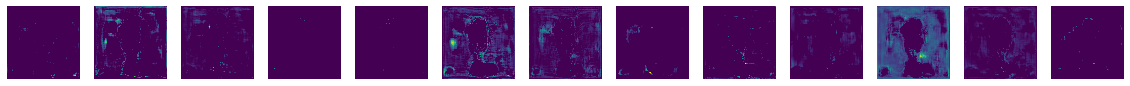

In [20]:
display(preds[0].data)

In [44]:
joints, _ = utils.get_heatmap_max(preds)

tensor(0.3141, grad_fn=<MaxBackward1>)
tensor(0.2693, grad_fn=<MaxBackward1>)
tensor(0.6862, grad_fn=<MaxBackward1>)
tensor(0.0916, grad_fn=<MaxBackward1>)
tensor(0.2778, grad_fn=<MaxBackward1>)
tensor(0.5628, grad_fn=<MaxBackward1>)
tensor(0.6255, grad_fn=<MaxBackward1>)
tensor(0.6610, grad_fn=<MaxBackward1>)
tensor(0.2908, grad_fn=<MaxBackward1>)
tensor(0.8198, grad_fn=<MaxBackward1>)
tensor(0.7838, grad_fn=<MaxBackward1>)
tensor(1.2352, grad_fn=<MaxBackward1>)
tensor(0.2285, grad_fn=<MaxBackward1>)


In [14]:
def plot_2d(dvs_frame, sample_gt, sample_pred):
    " To plot image and 2D ground truth and prediction "
    plt.figure()
    plt.imshow(dvs_frame, cmap='gray')
    plt.plot(sample_gt[:,1], sample_gt[:,0], '.', c='red', label='gt')
    plt.plot(sample_pred[:,1], sample_pred[:,0], '.', c='blue', label='pred')
    plt.legend()
    plt.savefig('x.png')

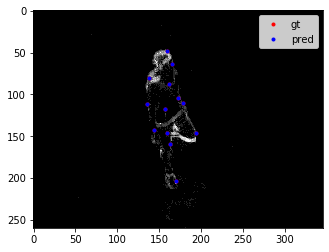

In [24]:
plot_2d(x.squeeze(), gt_info['joints'][0], gt_info['joints'][0])

In [3]:
display(preds[0])

NameError: name 'preds' is not defined

In [35]:
from importlib import reload 

In [45]:
import experimenting.models.metrics as metrics

reload(metrics)

<module 'experimenting.models.metrics' from '/home/gianscarpe/dev/event-camera/experimenting/models/metrics.py'>

In [46]:
mp = metrics.MPJPE()

In [48]:
r = mp(y, gt_info)

tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)


In [50]:
gt_info['joints']

tensor([[[ 48, 160],
         [ 80, 138],
         [ 64, 166],
         [111, 136],
         [ 87, 162],
         [117, 157],
         [104, 173],
         [143, 144],
         [110, 179],
         [159, 163],
         [146, 194],
         [204, 170],
         [146, 159]]], dtype=torch.int32)

In [51]:
get_heatmap_max(y)

tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)


(tensor([[[ 48, 160],
          [ 80, 138],
          [ 64, 166],
          [111, 136],
          [ 87, 162],
          [117, 157],
          [104, 173],
          [143, 144],
          [110, 179],
          [159, 163],
          [146, 194],
          [204, 170],
          [146, 159]]], dtype=torch.uint8),
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))